In [4]:
import sys
sys.path.append("../")  

import numpy as np 
import torch, time
import matplotlib.pyplot as plt
import utility, problem
import random
import net
from scipy.linalg import lstsq

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）


In [5]:
torch.set_default_dtype(torch.float64)
plt.rcParams.update({'font.size': 20})
def u_exact(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2)

def f(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return 2 * torch.pi**2 * torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2)


#### PD-ODM

c:\Users\29433\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss at Step 50 is 33.575544004597305 with pde loss 30.731739945922758 , orthogonal loss 284.38040586745433 and rank of matrix 24.
Loss at Step 100 is 7.061178497691644 with pde loss 3.557586931622931 , orthogonal loss 350.35915660687135 and rank of matrix 41.
Loss at Step 150 is 1.6147383351520974 with pde loss 0.3956803014730177 , orthogonal loss 121.90580336790798 and rank of matrix 44.
Loss at Step 200 is 1.063902248223835 with pde loss 0.25460785157208443 , orthogonal loss 80.92943966517504 and rank of matrix 46.
the l2 relative error in problem poisson2d:  0.3880125493218148
the maximum pointwise error in problem poisson2d:  0.857453742077063


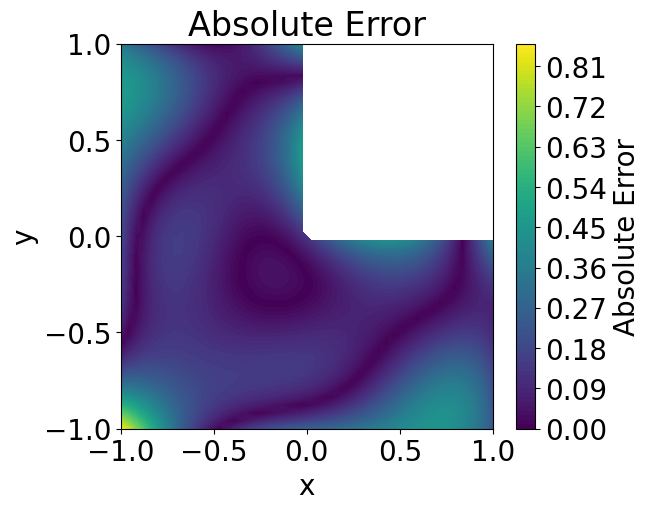

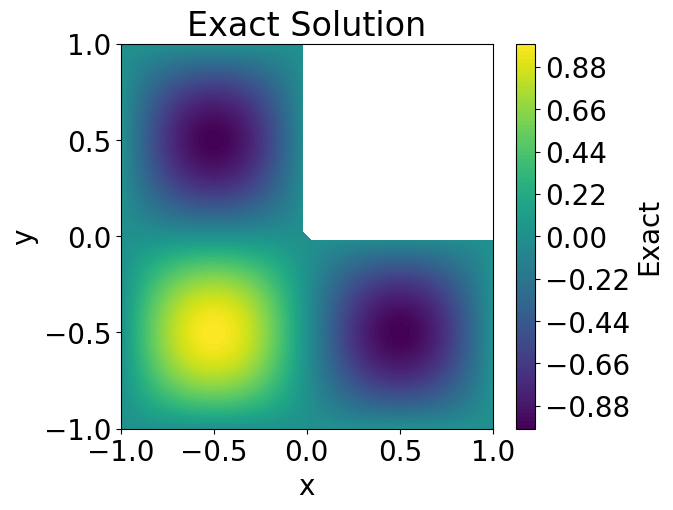

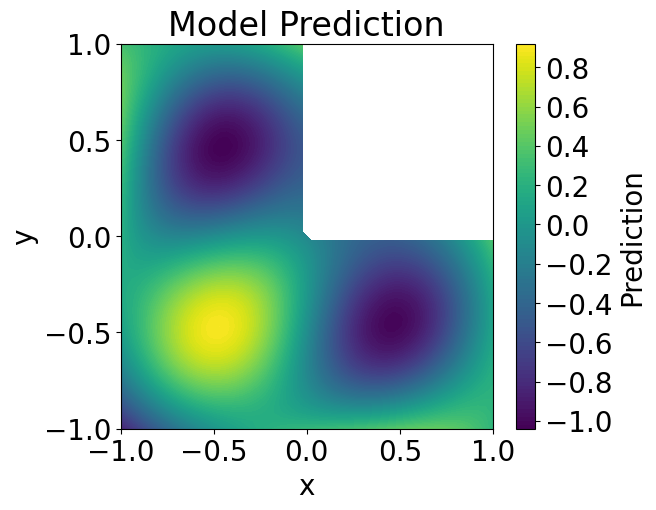

Loss at Step 250 is 0.7825216978372272 with pde loss 0.1248943240255916 , orthogonal loss 65.76273738116356 and rank of matrix 45.
Final Loss at Step 299 is 0.6576255966658389 with pde loss 0.09243044756997934 , orthogonal loss 56.51951490958595.
after least squares
the error of least square in problem poisson2d:  4.090410127878899e-08
the effective rank of basis in problem poisson2d is 45 with threshold 0.001
the l2 relative error in problem poisson2d:  6.480445584704006e-11
the maximum pointwise error in problem poisson2d:  2.6208435248420425e-10


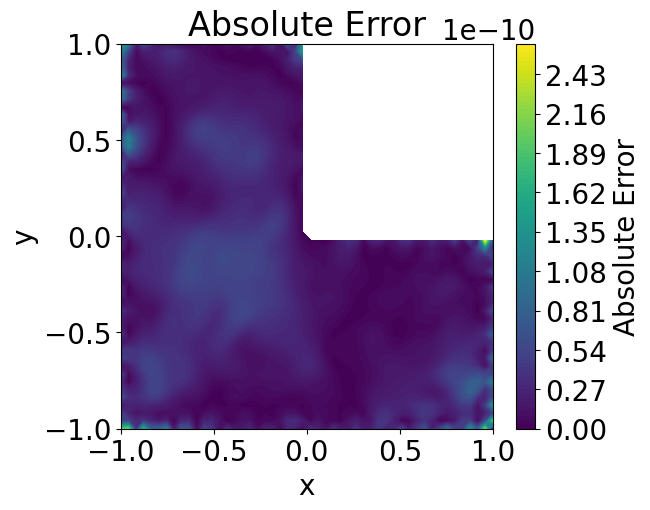

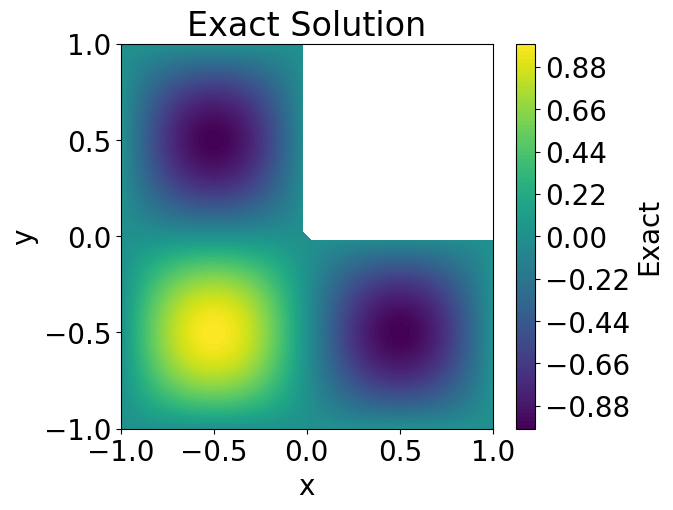

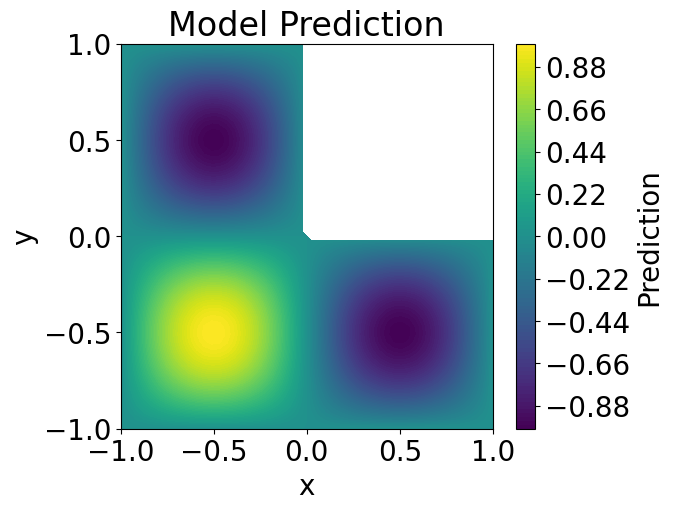

In [6]:
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Pro = problem.PoissonL(f, u_exact, u_exact, domain_size=1, device=device)
params = {"d": 2, "bodyBatch": 1024, "bdryBatch": 128, "lr": 0.001, "width": 500, "depth": 2, "trainStep": 1000, "plotStep": 200, "writeStep": 50, "decay": 0.0001, "lambda": 10, "epsilon": 1e-3, "orthogonalpenalty": 0.01}
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

rank_orthogonal, sigma_orthogonal = utility.trainnew(model,Pro,device,params,optimizer)

### PD-FM

Loss at Step 50 is 30.278863294756913 with pde loss 30.278863294756913 , orthogonal loss 1853.9699275836465 and rank of matrix 27.
Loss at Step 100 is 0.903939070311995 with pde loss 0.903939070311995 , orthogonal loss 14372.964893352246 and rank of matrix 52.
Loss at Step 150 is 0.23940444732229332 with pde loss 0.23940444732229332 , orthogonal loss 13877.815204211049 and rank of matrix 57.
Loss at Step 200 is 0.12374863165988446 with pde loss 0.12374863165988446 , orthogonal loss 14106.562003206427 and rank of matrix 58.
the l2 relative error in problem poisson2d:  0.5662014530688595
the maximum pointwise error in problem poisson2d:  0.7222475919547767


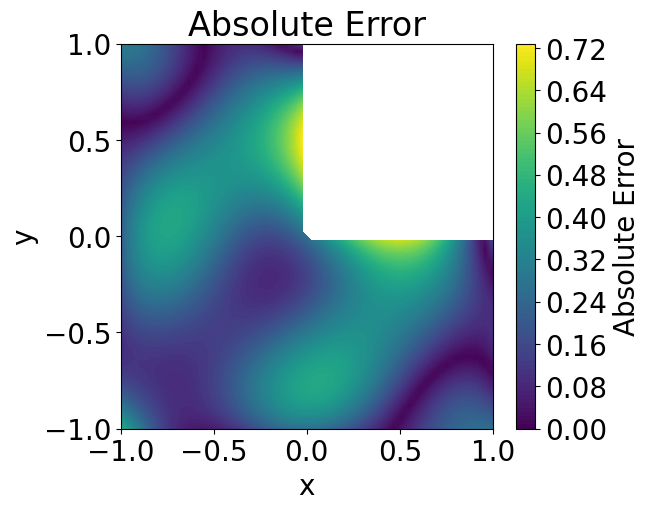

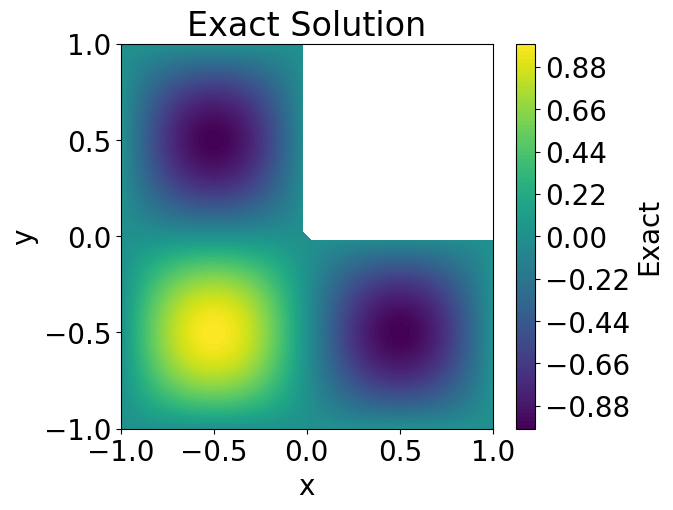

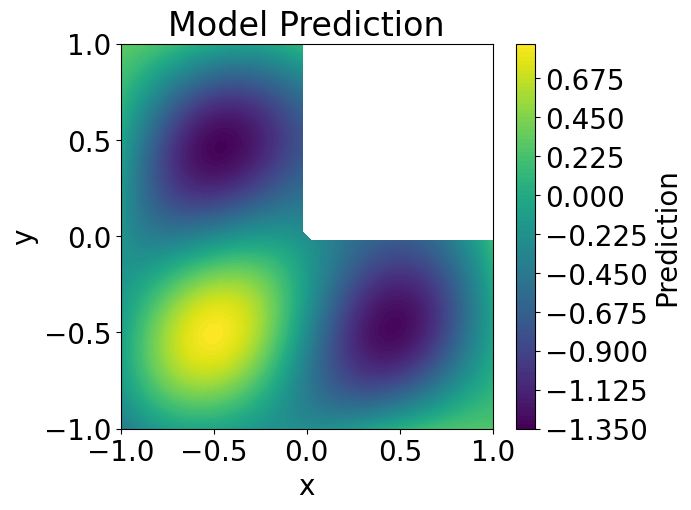

Final Loss at Step 239 is 0.08952241276372828 with pde loss 0.08952241276372828 , orthogonal loss 14331.031681892424.
after least squares
the error of least square in problem poisson2d:  5.983897691031144e-07
the effective rank of basis in problem poisson2d is 60 with threshold 0.001
the l2 relative error in problem poisson2d:  5.820643036184613e-09
the maximum pointwise error in problem poisson2d:  4.380975582307656e-08


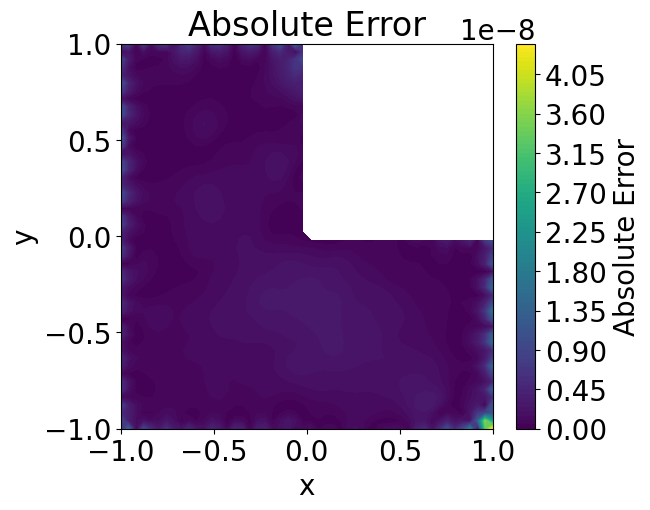

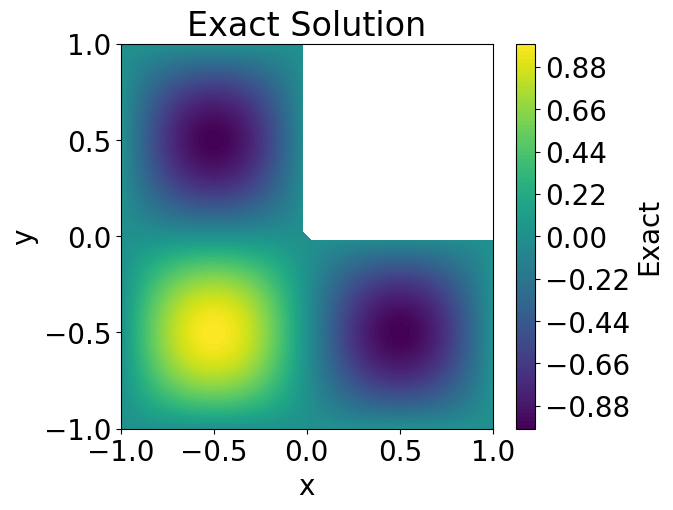

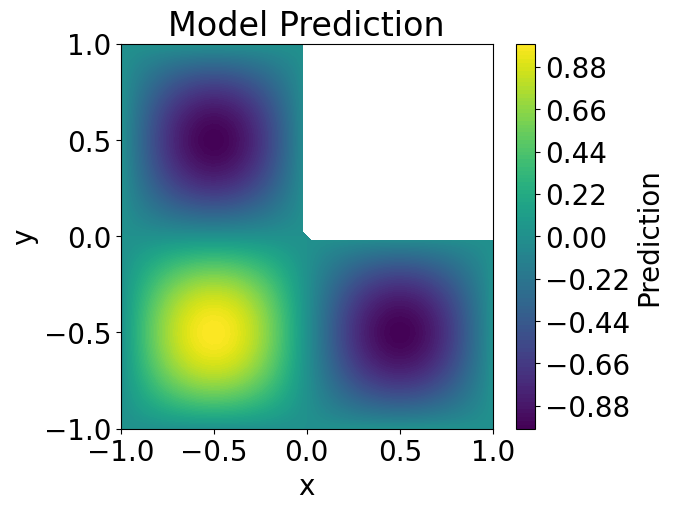

In [7]:
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Pro = problem.PoissonL(f, u_exact, u_exact, domain_size=1, device=device)
params = {"d": 2, "bodyBatch": 1024, "bdryBatch": 128, "lr": 0.001, "width": 500, "depth": 2, "trainStep": 1000, "plotStep": 200, "writeStep": 50, "decay": 0.0001, "lambda": 10, "epsilon": 1e-3, "orthogonalpenalty": 0}
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

rank_orthogonal, sigma_orthogonal = utility.trainnew(model,Pro,device,params,optimizer)

#### Transnet

best shape parameter:  2.0
the error of least square in problem poisson2d:  1.0443113780294785e-06
the effective rank of basis in problem poisson2d is 58 with threshold 0.001
the l2 relative error in problem poisson2d:  5.1582653660174815e-09
the maximum pointwise error in problem poisson2d:  2.125607070913027e-08


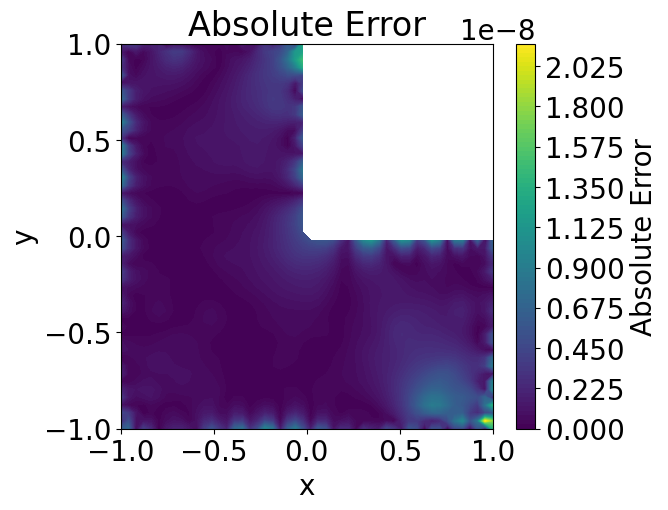

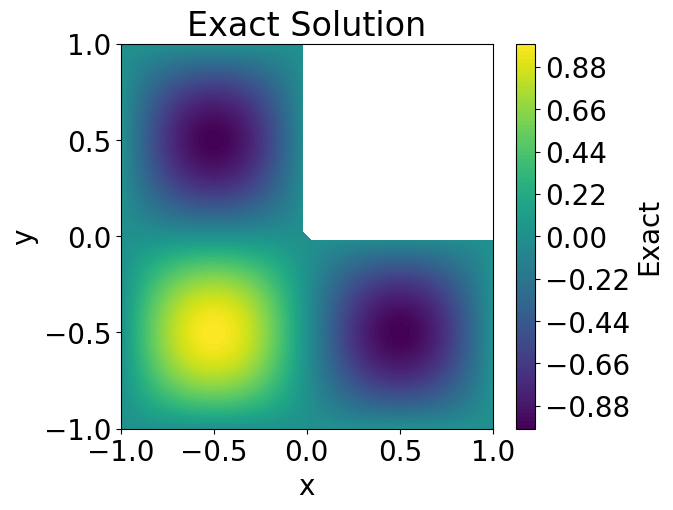

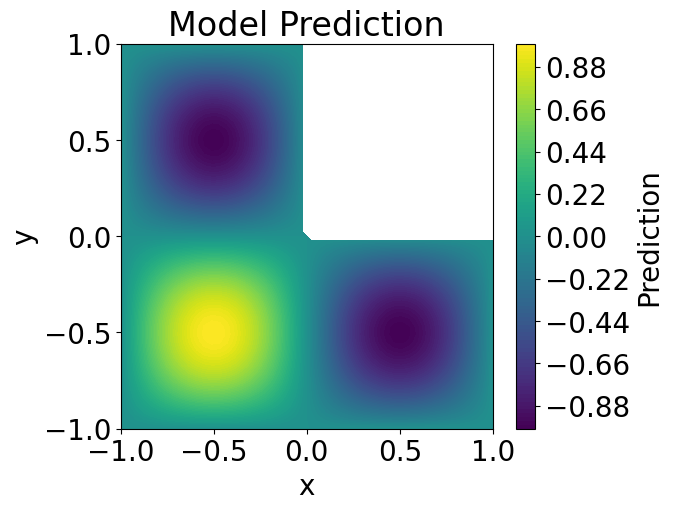

In [8]:
set_seed(42)

### Initializing TransNet and Problem
device = "cpu"
Pro = problem.PoissonL(f, u_exact, u_exact, domain_size=1, device=device)
params = dict()
params = {"radius": 1.5, "d": 2, "bodyBatch": 1024, "bdryBatch":128, "width": 500}
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
int_data = Pro.data()["interior_points"]
bdry_data = Pro.data()["boundary_points"]
int_data.requires_grad = True
bdry_data.requires_grad = True
model = net.TransNet(params["d"], params["width"], params["radius"], shape_parameter=2.0).to(device)
print("best shape parameter: ", model.shape_parameter)

### Solving Least Sqaure Problem
(A, rhs) = Pro.leastsquareproblem(model, int_data, bdry_data)
w, residuals, rank, s = lstsq(A, rhs)
U, s, Vh = torch.linalg.svd(model(int_data)[0].T@model(int_data)[0])
threshold = 1e-3
effective_rank = (s > threshold).sum()
error = A @ w - rhs
print("the error of least square in problem " + str(Pro.name)+": ", np.mean(np.abs(error)))
print("the effective rank of basis in problem %s is %s with threshold %s" % (str(Pro.name), effective_rank.detach().cpu().numpy(), threshold))

### Visualization
perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
Pro.plot(perdict)

### Random Feature Model

the error of least square in problem poisson2d:  3.262128759211362e-06
the effective rank of basis in problem poisson2d is 67 with threshold 0.001
the l2 relative error in problem poisson2d:  1.590163714107025e-06
the maximum pointwise error in problem poisson2d:  3.2392305210904304e-06


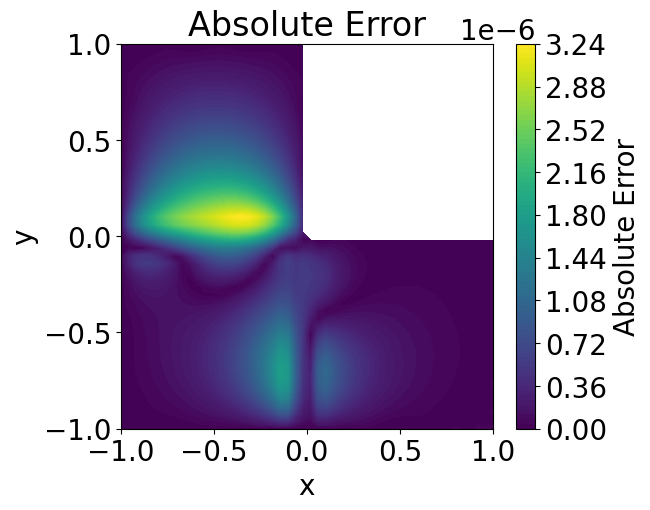

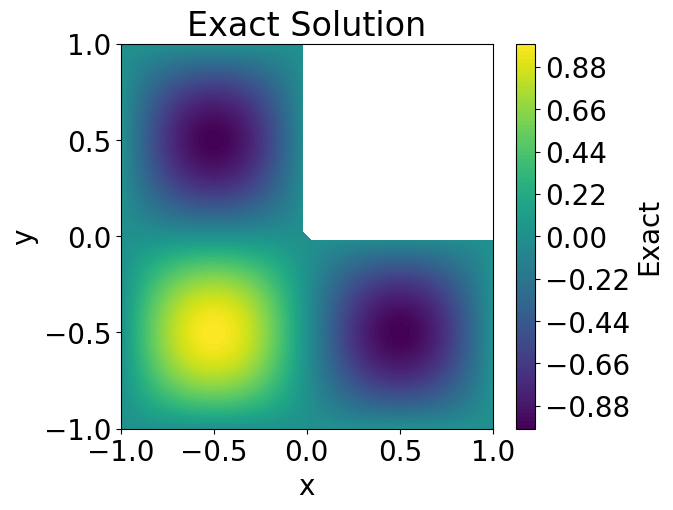

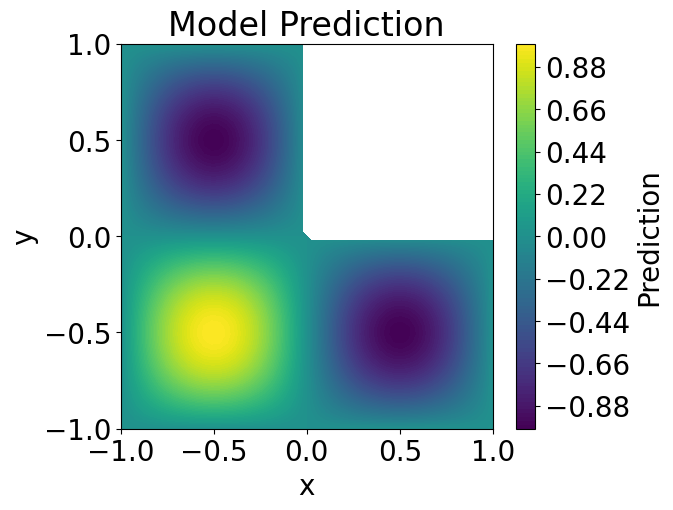

In [9]:
device="cpu"
set_seed(42)

### Initializing RFM and Problem
params = dict()
params = {"d": 2, "bodyBatch": 1024, "bdryBatch":128, "number_basis": 501}
centers = torch.tensor([[-0.5,0.5],[0.5,-0.5],[-0.5,-0.5]], dtype=torch.float64).to(device)
radius = torch.tensor([[0.5,0.5],[0.5,0.5],[0.5,0.5]], dtype=torch.float64).to(device)
model = net.RFM(params, centers, radius, typeofPoU="b", device=device).to(device)
Pro = problem.PoissonL(f, u_exact, u_exact, domain_size=1, bdry_penalty=0, device=device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"]) 
int_data = Pro.data()["interior_points"]
bdry_data = Pro.data()["boundary_points"]
int_data.requires_grad = True
bdry_data.requires_grad = True

### Solving Least Sqaure Problem
(A, rhs) = Pro.leastsquareproblem(model, int_data, bdry_data)
w, residuals, rank, s = lstsq(A, rhs)
U, s, Vh = torch.linalg.svd(model(int_data)[0].T@model(int_data)[0])
threshold = 1e-3
effective_rank = (s > threshold).sum()
error = A @ w - rhs
print("the error of least square in problem " + str(Pro.name)+": ", np.mean(np.abs(error)))
print("the effective rank of basis in problem %s is %s with threshold %s" % (str(Pro.name), effective_rank.detach().cpu().numpy(), threshold))

### Visualization
perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
Pro.plot(perdict)